# 04-Model Training

_[Estimated execution time: 9 min]_

The toolkit allows to train the models while fixing some parameters, in this notebook we will show:

* Training of the model
* Training while keeping some parameters fixed
* Saving and loading models

In [1]:
import mogptk
import numpy as np
import pandas as pd

## Load data set

For this tutorial we will use the air quality data set. The data set contains hourly averaged responses from an array of five metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located in the field in a significantly polluted area in an Italian city. Data were recorded for one year from March 2004 representing the longest freely available recordings of a deployed air quality chemical sensor device.

We will only use five columns: CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT). For more information on data loading check out [01 Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb). For more information on data handling check out [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

For each sensor the minimum value is -200, which is also the default value when there is an error in the measurements. We will ignore them by converting them to `NaN`.

In [2]:
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# Replace missing values with NaN
df.replace(-200.0, np.nan, inplace=True)

# First two columns are date and time
# We convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Define an initial date to compare all other to it
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# Get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# Use only the first eight days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
dataset = mogptk.LoadDataFrame(df2, x_col='Time', y_col=cols)

Remove aditional data to simulate sensor failure. In this case for each channel we will first remove 40% of the observations and then remove complete sectors in order to get reconstructions from the other channels through learned cross correlations.

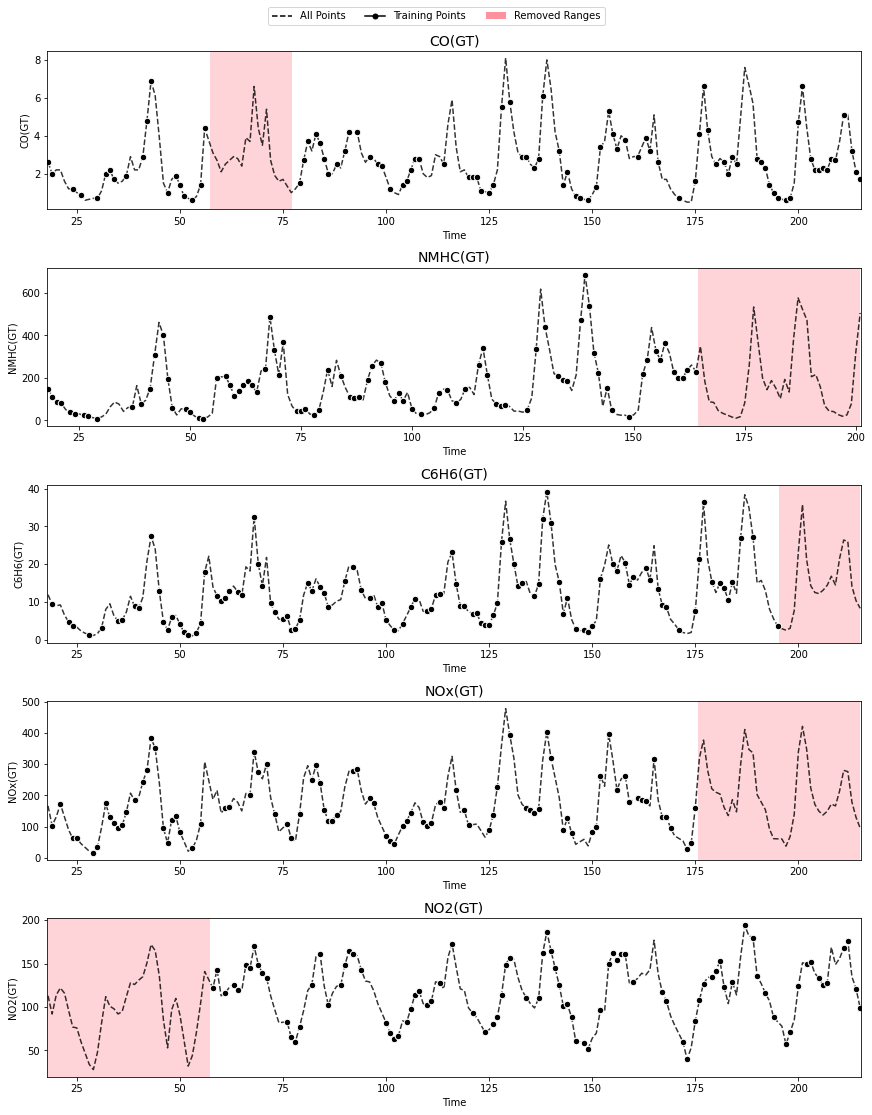

In [3]:
for channel in dataset:
    channel.remove_randomly(pct=0.4)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, 1.0)
dataset[2].remove_relative_range(0.9, 1.0)
dataset[3].remove_relative_range(0.8, 1.0)
dataset[4].remove_relative_range(0.0, 0.2)

for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))

dataset.plot();

## Create model

We create a multi output Gaussian Process with a MOSM kernel and initialize the parameters using BNSE.

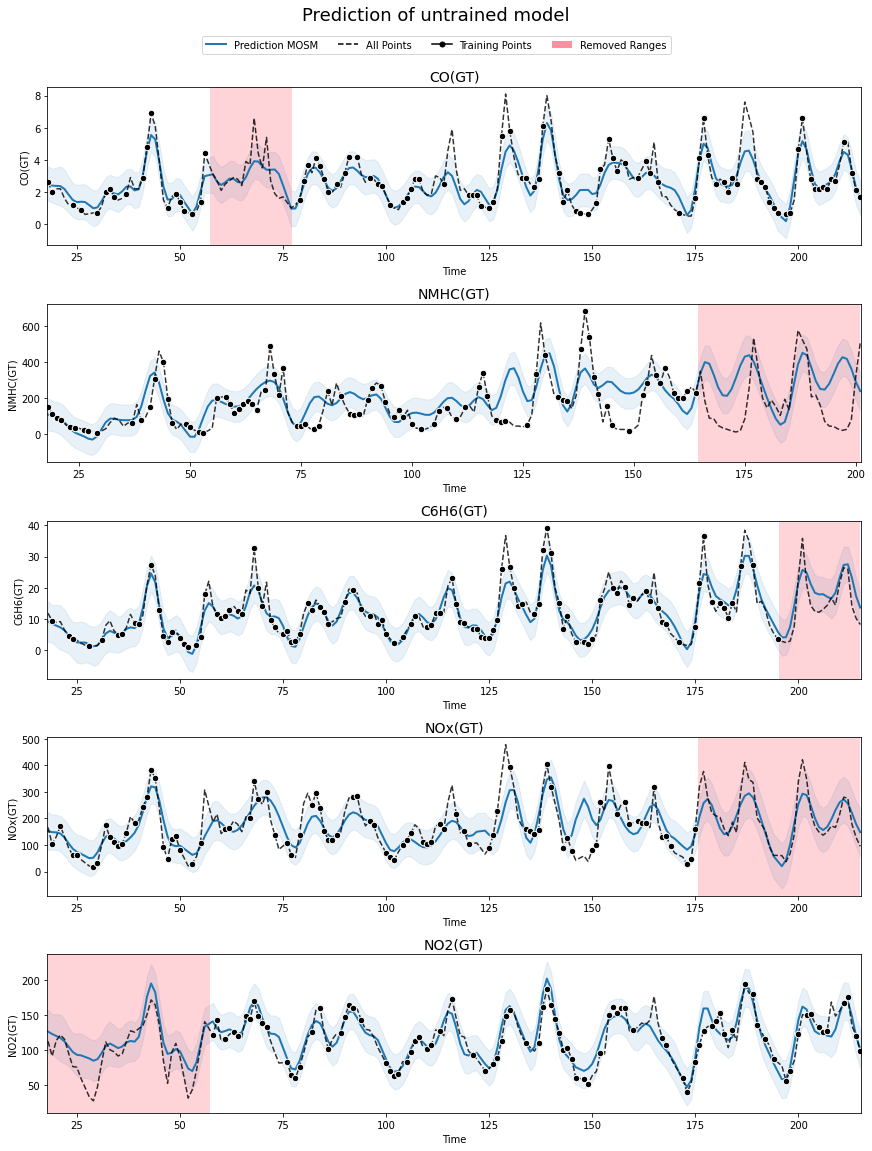

In [4]:
model = mogptk.MOSM(dataset, Q=3)
model.init_parameters('BNSE')

model.predict()
dataset.plot(title='Prediction of untrained model');

## Training mode

We now train the model using [`mogptk.model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.train) with a small number of iterations in order to get a preliminary estimation.

In [5]:
model.train(method='Adam', lr=0.5, iters=50, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 5
‣ Mixtures: 3
‣ Training points: 475
‣ Parameters: 90
‣ Initial NLL: 4.684

Optimization finished in 0.21 minutes
‣ Function evaluations: 50
‣ Final NLL: 3.663


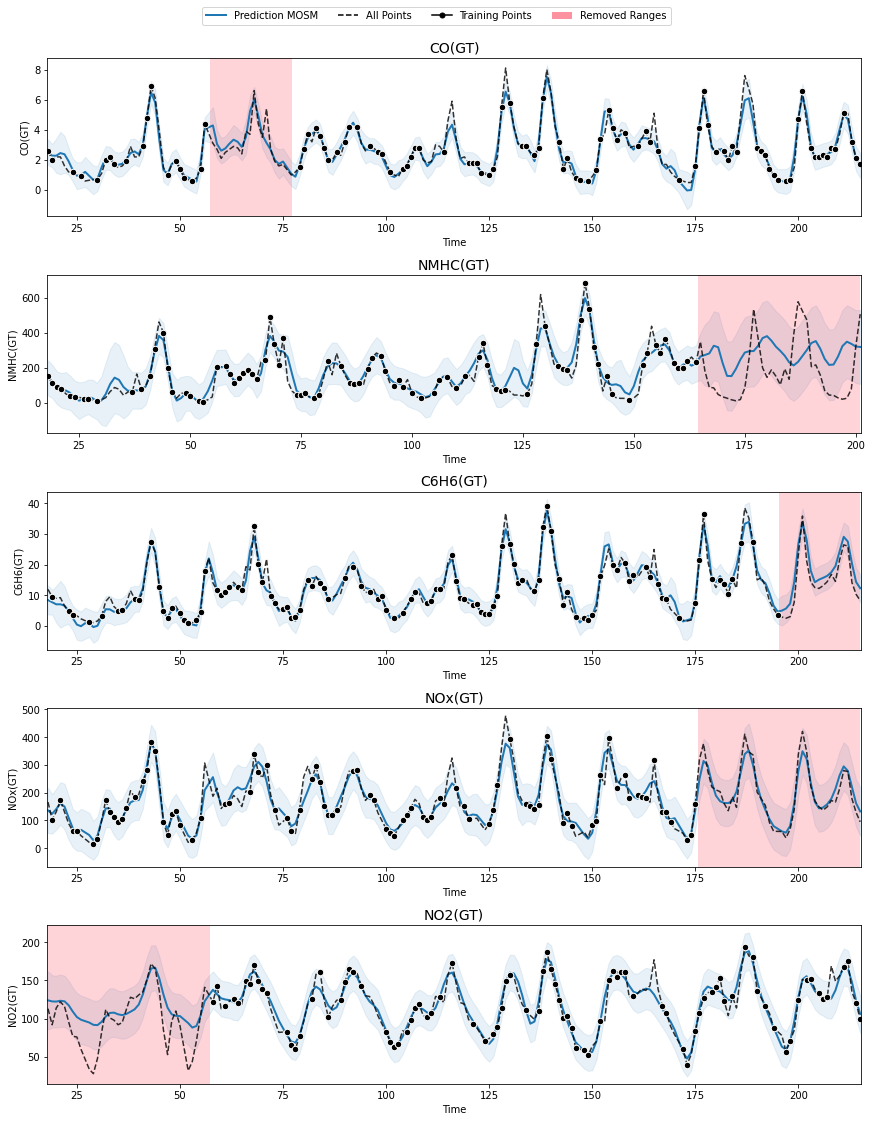

In [6]:
model.predict()
dataset.plot();

## Fixing parameters

We will now set the delay of the first component to zero and fix it so it is not being modified while optimizating. We will also fix the frequencies given that the periodicities were found fairly accurately in just a few iterations.

We can fix parameters by accessing the kernel in the model and setting `trainable=False`. We can also set the value of a parameter using `assign(value)`. Each kernel exposes different parameters and we can extract their names using the `print_parameters` function. Be sure to select the right mixture by indexing the `kernel` attribute of the model.

In [7]:
model.kernel[0].delay.assign(np.zeros(5), trainable=False)
model.kernel[0].mean.trainable = False
model.kernel[1].mean.trainable = False
model.kernel[2].mean.trainable = False

Now we can print which parameters are fixed and which are not

In [8]:
model.print_parameters()

Name,Range,Value
Mixture[0].MOSM.noise,"[1e-08,∞)",[3.28255267e-02 4.97133221e+02 8.92293833e-01 2.79717435e+02 3.41650647e+01]
Mixture[0].MOSM.magnitude,"[1e-08,∞)",[ 2.00907732 147.01353442 10.12712553 119.48500859 58.66839563]
Mixture[0].MOSM.mean,fixed,[[0.01708597] [0.01884256] [0.01313423] [0.01645948] [0.00450765]]
Mixture[0].MOSM.variance,"[1e-08,∞)",[[0.00668297] [0.00374425] [0.00665739] [0.00673163] [0.00333128]]
Mixture[0].MOSM.delay,fixed,[[0.] [0.] [0.] [0.] [0.]]
Mixture[0].MOSM.phase,"(-∞,∞)",[ 0.68032544 -1.71292624 0.65926415 0.84600642 0.62352933]
Mixture[1].MOSM.noise,"[1e-08,∞)",[3.28255267e-02 4.97133221e+02 8.92293833e-01 2.79717435e+02 3.41650647e+01]
Mixture[1].MOSM.magnitude,"[1e-08,∞)",[ 2.19225769 144.82901424 11.0497441 120.02722889 37.84865069]
Mixture[1].MOSM.mean,fixed,[[0.0128588 ] [0.00475169] [0.01304521] [0.01478082] [0.01572541]]
Mixture[1].MOSM.variance,"[1e-08,∞)",[[0.00460396] [0.00467903] [0.00375349] [0.00500774] [0.00244582]]


then we can train again, starting from the last parameters obtained, with some fixed values

In [9]:
model.train(method='Adam', lr=0.5, iters=50, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 5
‣ Mixtures: 3
‣ Training points: 475
‣ Parameters: 70
‣ Initial NLL: 3.666

Optimization finished in 0.28 minutes
‣ Function evaluations: 50
‣ Final NLL: 3.619


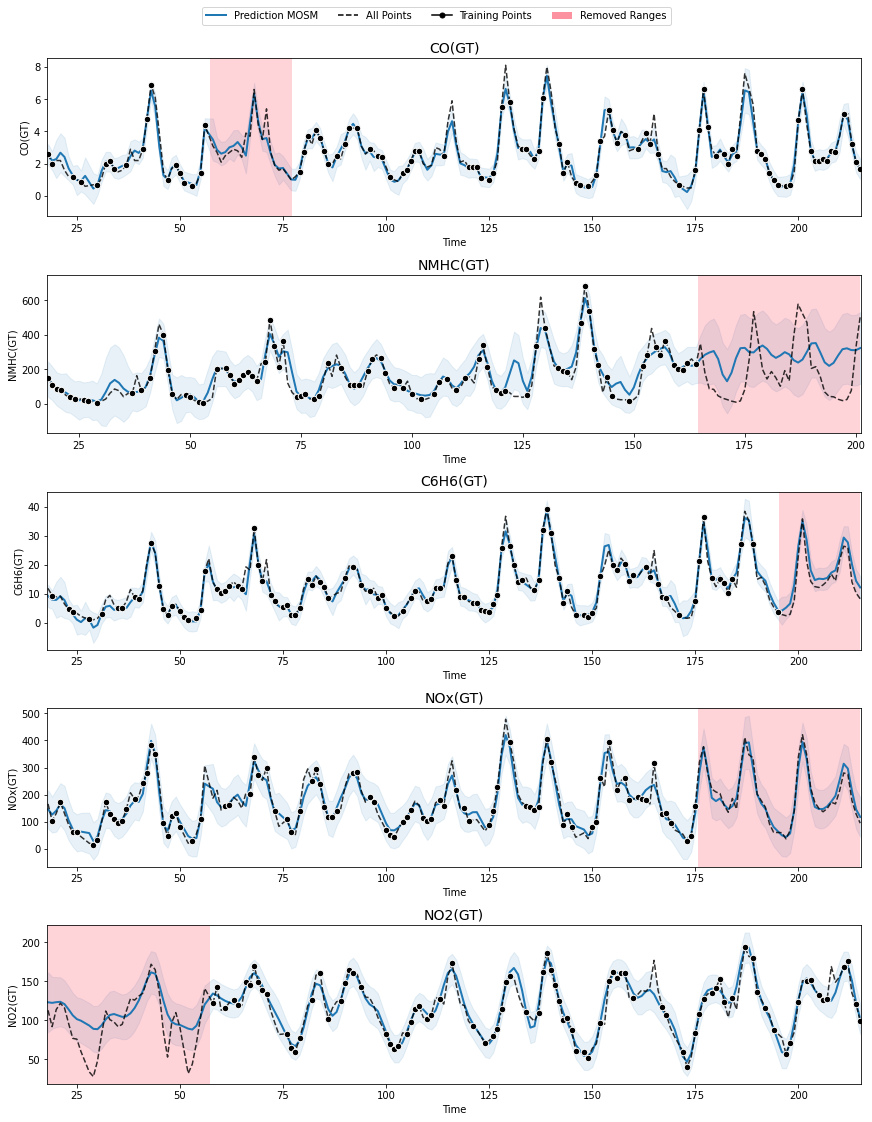

In [10]:
model.predict()
dataset.plot();

## Load and save models

In order to create checkpoints we can alternate between calls to [`model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.train) and [`model.save`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.save).

In [11]:
model.kernel[0].delay.trainable = True

In [12]:
checkpoints = 4
iters_per_checkpoint = 100

for i in range(checkpoints):
    model.train(method='Adam', lr=0.5, iters=iters_per_checkpoint)
    model.save('air_quality_mosm_%d' % (i,))

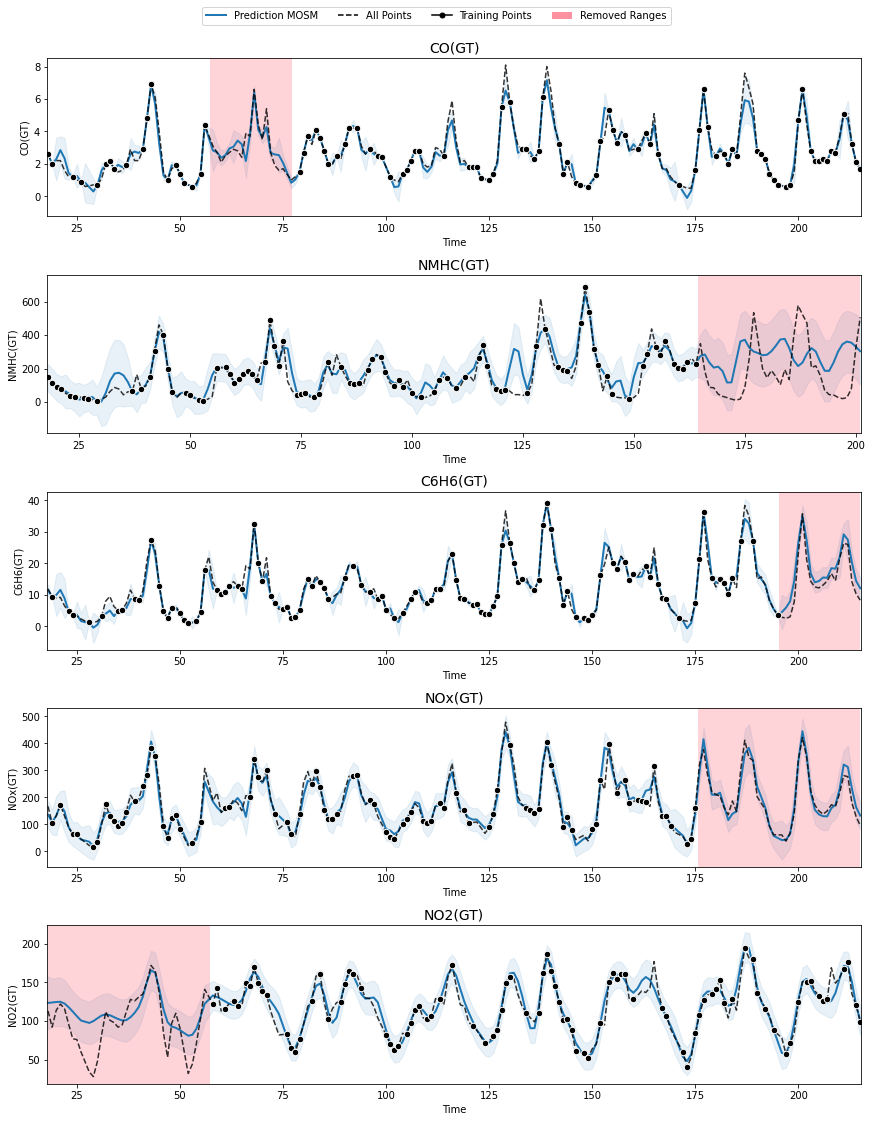

In [13]:
model.predict()
dataset.plot();

We can then load a model as follows.

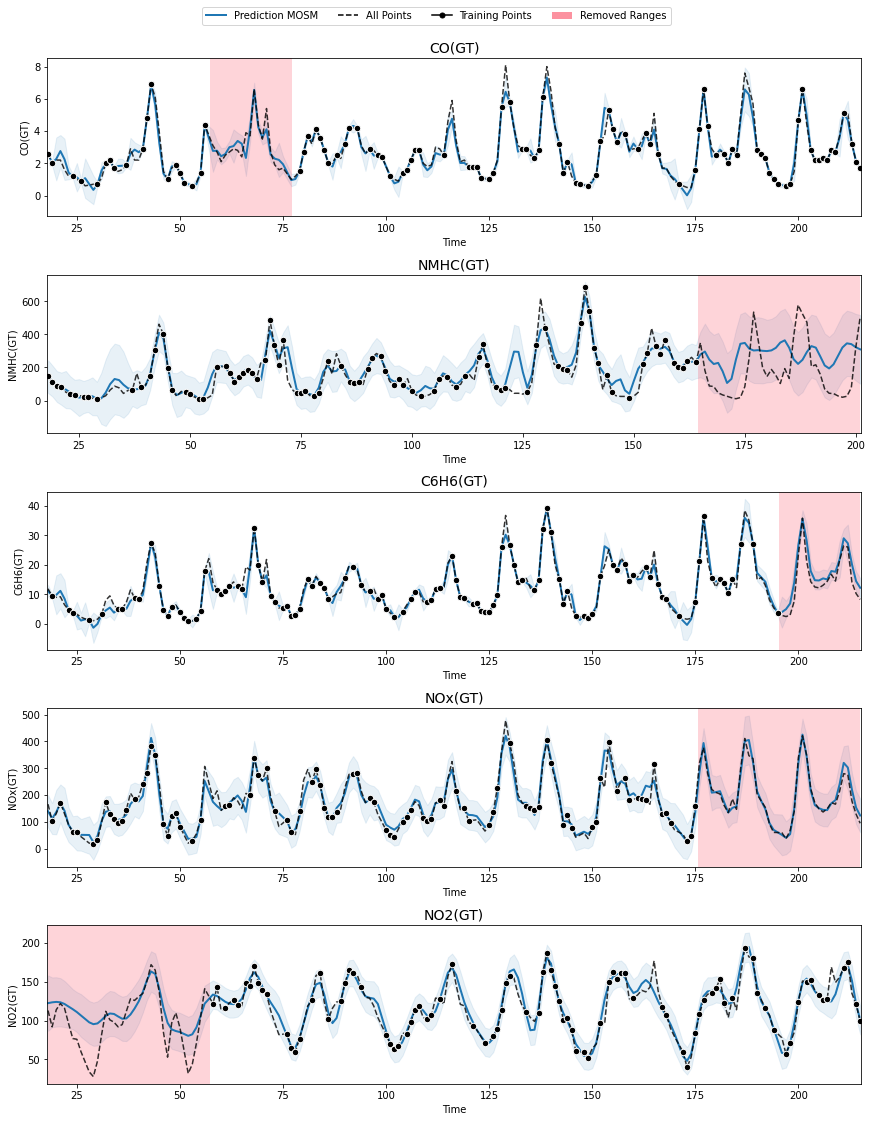

In [14]:
model = mogptk.LoadModel('air_quality_mosm_0')
model.predict()
model.dataset.plot();